In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


/var/folders/yl/gn9fldpj69169vhn466y4klh0000gn/T/ipykernel_20504/3647894513.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval=interval, period=PERIOD)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,BB_SMA,BB_STD,Upper_Band,Lower_Band,MACD_Strategy,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
6171,183.828506,188.107498,183.785995,185.634506,98734000,177.789681,175.660188,2.129493,1.347686,0.781807,173.679250,5.504233,179.183483,168.175016,NaN,NaN,NaN,0,NaN,NaN
6172,178.628494,185.673004,178.375000,183.819000,96844000,177.922714,175.928883,1.993830,1.478118,0.515712,174.309750,5.298919,179.608669,169.010830,1.0,-1.0,0.0,0,-0.028287,0.000000
6173,179.001999,181.052505,176.385498,179.251999,73804000,178.093075,176.201855,1.891221,1.561353,0.329868,174.819675,5.231435,180.051109,169.588240,1.0,0.0,1.0,0,-0.026255,0.000000
6174,179.020493,180.682007,176.842499,178.133499,46560000,178.238882,176.447941,1.790941,1.607543,0.183398,175.289474,5.161767,180.451242,170.127707,1.0,0.0,1.0,0,-0.026155,0.000000
6175,175.227997,181.675003,175.207504,180.104996,59826000,177.767108,176.343096,1.424012,1.570663,-0.146651,175.434449,5.114732,180.549181,170.319717,1.0,0.0,1.0,0,-0.046786,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7147,220.070007,220.679993,217.039993,217.699997,37809700,222.086690,223.939100,-1.852410,-1.710374,-0.142036,223.561501,5.203924,228.765424,218.357577,-1.0,1.0,0.0,0,0.197148,-0.040092
7148,216.389999,219.320007,212.600006,215.559998,45665600,221.210276,223.399879,-2.189602,-1.806220,-0.383382,222.678500,4.814253,227.492753,217.864248,-1.0,0.0,-1.0,0,0.177130,-0.040092
7149,215.570007,217.710007,212.660004,216.619995,45909500,220.342543,222.840602,-2.498060,-1.944588,-0.553472,221.876001,4.577196,226.453197,217.298805,-1.0,1.0,0.0,0,0.172669,-0.040092
7150,214.470001,218.589996,212.809998,215.669998,42414600,219.439075,222.242702,-2.803627,-2.116396,-0.687232,221.038001,4.300370,225.338372,216.737631,-1.0,1.0,0.0,0,0.166685,-0.040092


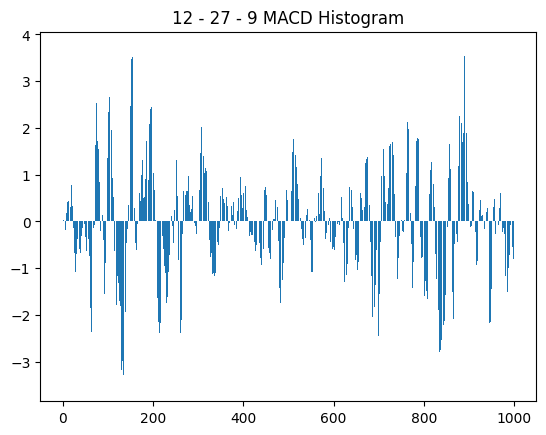

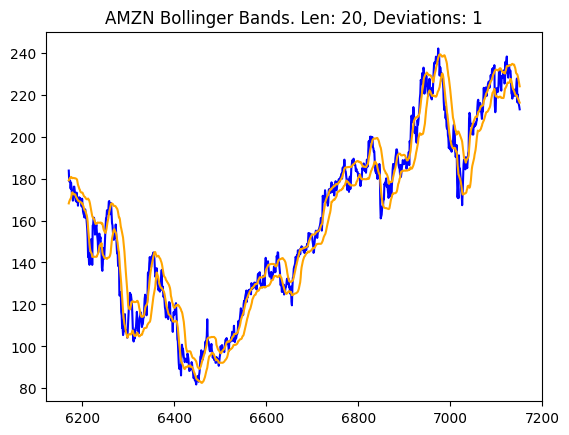

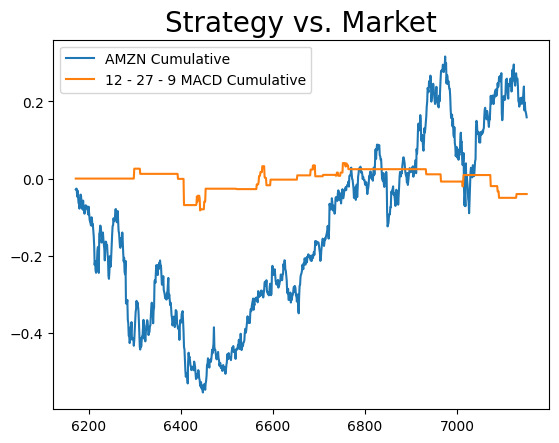

In [4]:
TICKER = 'AMZN'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
BB_LEN = 20
DEVS = 1

# what subsetion of that data are you interested in
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    
    return df

def add_bollinger_bands(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(
        df['Close'] > df['Upper_Band'], -1, 
        np.where(df['Close'] < df['Lower_Band'], 1, 0)
        )
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['BB_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_bollinger_bands(df)
    df = add_MACD_strategy(df)
    df = add_BB_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df